In [2]:
import time, random
import numpy as np
# import pennylane as qml
# from qiskit import Aer, transpile, execute
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import random_clifford, Pauli, Statevector
import matplotlib.pyplot as plt

np.set_printoptions(precision=6, edgeitems=10, linewidth=150, suppress=True)

In [3]:
import qiskit
import itertools
from qiskit import *
from qiskit.quantum_info import Clifford, random_clifford
from qiskit.synthesis import synth_clifford_full
from qiskit.quantum_info import hellinger_fidelity as hf

from utils.pauli_checks import ChecksFinder, add_pauli_checks, add_meas_pauli_checks, add_linear_meas_pauli_checks,  search_for_pauli_list
from utils.pauli_checks import gen_initial_layout, gen_final_layout, filter_results, pauli_strings_commute

from utils.utils import norm_dict, total_counts
# from utils.vqe_utils import evaluation
from utils.postprocess import singlecheck_postprocess, rightchecks_postprocess, filter_results_reindex

In [40]:
# Load the errors dictionary from the .npz file
loaded_data = np.load('data/expectations_4-qubit_full_connect_p2=0.02.npz')
loaded_data = np.load('expectations_fakeCairo.npz')
expectations = {key: loaded_data[key] for key in loaded_data.files}

In [41]:
# print(expectations)

In [42]:
def hydrogen_trial_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    # prepare the Hartree-Fock state
    qc.x(0)
    qc.x(1)
    
    qc.rx(np.pi/2, 0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    
    qc.cx(0,1)
    qc.cx(1,2)
    qc.cx(2,3)
    
    qc.rz(1.0, 3)
    
    qc.cx(2,3)
    qc.cx(1,2)
    qc.cx(0,1)
    
    qc.rx(-np.pi/2, 0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    
    return qc

num_qubits = 4
num_of_checks = 4
shadow_range = [100, 400, 1000, 4000, 10000]

# run the classical shadows postprocessing to get expectation values;

Paulis = ['XXXX', 'YYYY', 'XYXY', 'YXYX', 'YYXX', 'XXYY', 'ZZZZ', 'ZZII', 'IIZZ',
         'XZXZ', 'ZXZX', 'ZZXX', 'XXZZ', 'IIXX', 'XXII', 'XIIX']

operator_list = []
for pauli in Paulis:
    operator_list.append(Pauli(pauli))

psi = Statevector(hydrogen_trial_circuit(num_qubits))
ref_list = []
for operator in operator_list:
    expect = np.array(psi).T.conj() @ operator.to_matrix() @ np.array(psi)
    ref_list.append(expect)

In [43]:
errors = {
    name: np.zeros(len(shadow_range))
    for name in ["shadow", "shadow_r", "noiseless"]
    + [f"check{k+1}" for k in range(num_of_checks)]
    + [f"prepcheck{k+1}" for k in range(num_of_checks)]
}
for i in range(len(shadow_range)):
    errors['shadow'][i] = np.mean([np.abs(np.median(expectations["shadow"][i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    errors['shadow_r'][i] = np.mean([np.abs(np.median(expectations["shadow_r"][i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])  
    errors['noiseless'][i] = np.mean([np.abs(np.median(expectations["noiseless"][i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    for k in range(num_of_checks):
        errors[f"check{k+1}"][i] = np.mean([np.abs(np.median(expectations[f"check{k+1}"][i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    for k in range(num_of_checks):
        errors[f"prepcheck{k+1}"][i] = np.mean([np.abs(np.median(expectations[f"prepcheck{k+1}"][i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])

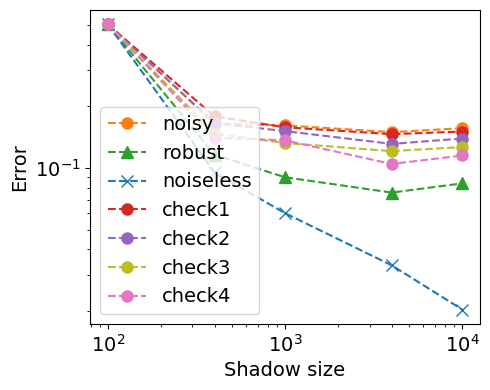

In [44]:
plt.figure(figsize=(5, 4), dpi=100)
plt.plot(shadow_range, errors['shadow'], '--o', ms=8, color='tab:orange', label='noisy')
plt.plot(shadow_range, errors['shadow_r'], '--^', ms=8, color='tab:green', label='robust')
plt.plot(shadow_range, errors['noiseless'], '--x', ms=8, color='tab:blue', label='noiseless')
plt.plot(shadow_range, errors['check1'], '--o', ms=8, color='tab:red', label='check1')
plt.plot(shadow_range, errors['check2'], '--o', ms=8, color='tab:purple', label='check2')
plt.plot(shadow_range, errors['check3'], '--o', ms=8, color='tab:olive', label='check3')
plt.plot(shadow_range, errors['check4'], '--o', ms=8, color='tab:pink', label='check4')
plt.legend(fontsize=14, loc='best')
plt.xlabel('Shadow size', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('4-qubit_randomclifford_depolar_p2=0.02.png', dpi=100, bbox_inches="tight")
plt.show()

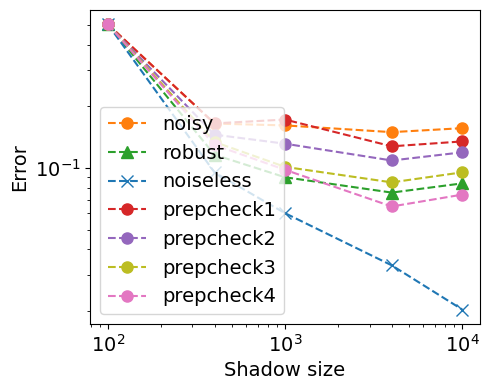

In [45]:
plt.figure(figsize=(5, 4), dpi=100)
plt.plot(shadow_range, errors['shadow'], '--o', ms=8, color='tab:orange', label='noisy')
plt.plot(shadow_range, errors['shadow_r'], '--^', ms=8, color='tab:green', label='robust')
plt.plot(shadow_range, errors['noiseless'], '--x', ms=8, color='tab:blue', label='noiseless')
plt.plot(shadow_range, errors['prepcheck1'], '--o', ms=8, color='tab:red', label='prepcheck1')
plt.plot(shadow_range, errors['prepcheck2'], '--o', ms=8, color='tab:purple', label='prepcheck2')
plt.plot(shadow_range, errors['prepcheck3'], '--o', ms=8, color='tab:olive', label='prepcheck3')
plt.plot(shadow_range, errors['prepcheck4'], '--o', ms=8, color='tab:pink', label='prepcheck4')
plt.legend(fontsize=14, loc='best')
plt.xlabel('Shadow size', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

Calculate Extrapolated Checks

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

check_numbers = [1, 2, 3]  # Original check layers
extrapolation_layers = range(4, 5)  # Layers we extrapolate to
medians = [np.median(check, axis=2) for check in [expectations[f"prepcheck{k+1}"] for k in range(len(check_numbers))]]

# Initialize a three-dimensional array to store extrapolated values
# Dimensions: [extrapolated layers, shadow size, Paulis]
expectation_check_limit = np.zeros((len(extrapolation_layers), len(shadow_range), len(Paulis)))

for layer_index, layer in enumerate(extrapolation_layers):
    for shadow_size_index in range(len(medians[0])):
        for pauli_index in range(medians[0].shape[1]):
            expectation_values = [median[shadow_size_index, pauli_index] for median in medians]
            polynomial = Polynomial.fit(check_numbers, expectation_values, 1)
            # Extrapolate the value for the current layer
            extrapolated_value = polynomial(layer)
            expectation_check_limit[layer_index, shadow_size_index, pauli_index] = extrapolated_value

Compute mean error across observables for each extrapolated check

In [47]:
error_check_limit = np.zeros((len(extrapolation_layers), len(shadow_range)))

for layer_index, layer in enumerate(extrapolation_layers):
    for shadow_size_index in range(len(shadow_range)):
        # Calculate the mean error for this layer and shadow size across all Pauli indices
        error_check_limit[layer_index, shadow_size_index] = np.mean(
            [np.abs(expectation_check_limit[layer_index, shadow_size_index, pauli_index] - ref_list[pauli_index]) for pauli_index in range(len(Paulis))]
        )

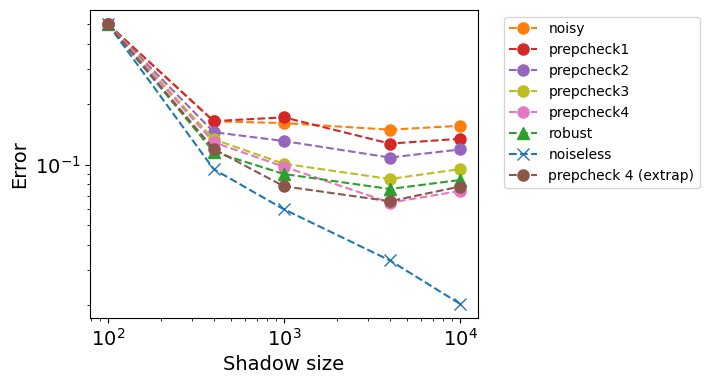

In [48]:
plt.figure(figsize=(5, 4), dpi=100)
plt.plot(shadow_range, errors['shadow'], '--o', ms=8, color='tab:orange', label='noisy')
plt.plot(shadow_range, errors['prepcheck1'], '--o', ms=8, color='tab:red', label='prepcheck1')
plt.plot(shadow_range, errors['prepcheck2'], '--o', ms=8, color='tab:purple', label='prepcheck2')
plt.plot(shadow_range, errors['prepcheck3'], '--o', ms=8, color='tab:olive', label='prepcheck3')
plt.plot(shadow_range, errors['prepcheck4'], '--o', ms=8, color='tab:pink', label='prepcheck4')
plt.plot(shadow_range, errors['shadow_r'], '--^', ms=8, color='tab:green', label='robust')
plt.plot(shadow_range, errors['noiseless'], '--x', ms=8, color='tab:blue', label='noiseless')

# Plotting each layer of extrapolated checks
colors = ['tab:brown', 'tab:gray', 'tab:cyan', 'tab:pink', 'tab:purple']  # Example colors for different layers
for layer_index, layer in enumerate(extrapolation_layers):
    plt.plot(shadow_range, error_check_limit[layer_index, :], '--o', ms=8, color=colors[layer_index % len(colors)], label=f'prepcheck {layer} (extrap)')

# plt.legend(fontsize=14, loc='best')
# plt.xlabel('Shadow size', fontsize=14)
# plt.ylabel('Error', fontsize=14)
# plt.xscale('log')
# plt.yscale('log')
# plt.tick_params(labelsize=14)
# plt.tight_layout()

# plt.savefig('non_ideal_checks.png', dpi=100)
# plt.show()

# Adjust the legend to be outside without altering the figure size
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xlabel('Shadow size', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=14)

# Note: The figure's layout isn't altered with plt.tight_layout() in this case
# Saving the figure with bbox_inches='tight' includes the external legend
plt.savefig('4-qubit_stateprep_depolar_p2=0.02.png', dpi=100, bbox_inches="tight")
plt.show()


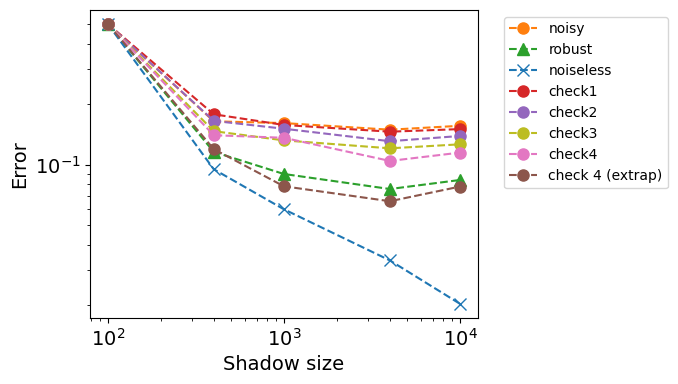

In [49]:
plt.figure(figsize=(5, 4), dpi=100)
plt.plot(shadow_range, errors['shadow'], '--o', ms=8, color='tab:orange', label='noisy')
plt.plot(shadow_range, errors['shadow_r'], '--^', ms=8, color='tab:green', label='robust')
plt.plot(shadow_range, errors['noiseless'], '--x', ms=8, color='tab:blue', label='noiseless')
plt.plot(shadow_range, errors['check1'], '--o', ms=8, color='tab:red', label='check1')
plt.plot(shadow_range, errors['check2'], '--o', ms=8, color='tab:purple', label='check2')
plt.plot(shadow_range, errors['check3'], '--o', ms=8, color='tab:olive', label='check3')
plt.plot(shadow_range, errors['check4'], '--o', ms=8, color='tab:pink', label='check4')

# Plotting each layer of extrapolated checks
colors = ['tab:brown', 'tab:gray', 'tab:cyan', 'tab:pink', 'tab:purple']  # Example colors for different layers
for layer_index, layer in enumerate(extrapolation_layers):
    plt.plot(shadow_range, error_check_limit[layer_index, :], '--o', ms=8, color=colors[layer_index % len(colors)], label=f'check {layer} (extrap)')

# Adjust the legend to be outside without altering the figure size
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xlabel('Shadow size', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=14)

plt.savefig('4-qubit_randomclifford_depolar_p2=0.02.png', dpi=100, bbox_inches="tight")
plt.show()